In [1]:
#imports
import pandas as pd
import scipy 
from scipy import stats
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Collection:

In [2]:
#imported xlsx files, downloaded from sources

# Preprocessing:

In [3]:
#PLAN - find yearly avg global temp, add to each entry according to year, find avg estimate for each unique indicator_name in each year, use the appropriate indicator_names to form a score for inequality and train model on x - temp, year | y-inequality scale

df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')
df = df.dropna()
df = df.drop(columns='AverageTemperatureUncertainty')
#dt column -> date: yy/mm/dd
#get an average temp for each year
df['dt'] = pd.to_datetime(df['dt'])
df['year'] = df['dt'].dt.year
yearly_avg_temp = df.groupby('year')['AverageTemperature'].mean().reset_index()

yearly_temps = yearly_avg_temp.set_index('year')['AverageTemperature'].to_numpy()
unique_years_enviro = df['year'].unique()
#to get yearly avg temp for a year -> yearly_temps[desired year - 1743]

df = pd.read_excel('enviro_data.xlsx')
print(df.head())

                            setting  date                         source  \
0                      Saudi Arabia  2019  WHO Global Health Observatory   
1                             Yemen  2019  WHO Global Health Observatory   
2                         Lithuania  2019  WHO Global Health Observatory   
3                       Switzerland  2019  WHO Global Health Observatory   
4  Saint Vincent and the Grenadines  2019  WHO Global Health Observatory   

       indicator_abbr                                     indicator_name  \
0  AIR_17_ENVCAUSE000  Household air pollution attributable DALYs (pe...   
1  AIR_17_ENVCAUSE000  Household air pollution attributable DALYs (pe...   
2  AIR_17_ENVCAUSE000  Household air pollution attributable DALYs (pe...   
3  AIR_17_ENVCAUSE000  Household air pollution attributable DALYs (pe...   
4  AIR_17_ENVCAUSE000  Household air pollution attributable DALYs (pe...   

  dimension subgroup     estimate  se       ci_lb  ...  iso3  \
0       Sex     Male  

In [4]:
#target -> health inequality 
#POA -> for each year, find the average estimate for each indicator_name type
# -> then append a yearly_avg_temp column that will contain the avg temp for the year fo the entry
df = df.groupby(['date', 'indicator_name'])['estimate'].mean().reset_index()
print(df.info())
indicator_names = df['indicator_name'].unique()
file = open('unique_values.txt', 'w')
file.write(str(indicator_names))
file.close()

file = open('unique_years.txt', 'w')
file.write(str(unique_years_enviro))
file.close()
#relevant columns from the WHO data -> 'date', 'indicator_name', 'subgroup' 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459 entries, 0 to 458
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            459 non-null    int64  
 1   indicator_name  459 non-null    object 
 2   estimate        459 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ KB
None


In [5]:
df = df[df['date'].isin(unique_years_enviro)]
df = df.iloc[:281] #only have temp up to 2013
avg_temp_year = []
for row in df.itertuples():
    avg_temp_year.append(yearly_temps[row.date - 1784])

df['avg_yearly_temp'] = avg_temp_year
print(df.head())

   date                                     indicator_name   estimate  \
0  1990  Population with primary reliance on biomass fo...  46.111466   
1  1990  Population with primary reliance on charcoal f...   5.958083   
2  1990  Population with primary reliance on clean fuel...  53.233639   
3  1990  Population with primary reliance on coal for c...   1.835902   
4  1990  Population with primary reliance on electricit...   5.129699   

   avg_yearly_temp  
0         18.85564  
1         18.85564  
2         18.85564  
3         18.85564  
4         18.85564  


In [6]:
#noramlize between 0 and 1
df['estimate'] = (df['estimate'] - df['estimate'].min())/(df['estimate'].max() - df['estimate'].min())

print(df.head())

   date                                     indicator_name  estimate  \
0  1990  Population with primary reliance on biomass fo...  0.537405   
1  1990  Population with primary reliance on charcoal f...  0.062276   
2  1990  Population with primary reliance on clean fuel...  0.621680   
3  1990  Population with primary reliance on coal for c...  0.013499   
4  1990  Population with primary reliance on electricit...  0.052474   

   avg_yearly_temp  
0         18.85564  
1         18.85564  
2         18.85564  
3         18.85564  
4         18.85564  


In [7]:
yearly_health_ineq_factors = []
estimates = []
start_year = 1990
unique_years_df = [1990]
for row in df.itertuples():
    if row.date == start_year:
        estimates.append(row.estimate)
    else:
        total = sum(estimates)
        total *= (1/len(estimates))
        yearly_health_ineq_factors.append(total)
        estimates = []
        estimates.append(row.estimate)
        start_year += 1
        unique_years_df.append(start_year)
        
estimates = []
for row in df.itertuples():
    if row.date == 2013:
        estimates.append(row.estimate)
        
total = sum(estimates)
total *= (1/len(estimates))
yearly_health_ineq_factors.append(total)

print(unique_years_df)
#put on a scale of 10
stand_factors = [10 * (value - min(yearly_health_ineq_factors)) / (max(yearly_health_ineq_factors) - min(yearly_health_ineq_factors)) for value in yearly_health_ineq_factors]

[1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


In [8]:
#standardize temp
stand_temps = yearly_temps[-24:]
stand_temps = [(value - min(yearly_temps))/(max(yearly_temps) - min(yearly_temps)) for value in stand_temps]

In [9]:
df = pd.DataFrame({ 'year': list(range(1990, 2014)), 'health_ineq_factor':stand_factors, 'stand_temp':stand_temps, 'temp':yearly_temps[-24:]})
print(df)

    year  health_ineq_factor  stand_temp       temp
0   1990            0.000000    0.969750  19.317686
1   1991            0.058337    0.953183  19.011360
2   1992            0.111932    0.951054  18.972007
3   1993            0.160216    0.948826  18.930800
4   1994            0.205358    0.966181  19.251702
5   1995            0.246369    0.967012  19.267070
6   1996            0.280697    0.950317  18.958375
7   1997            0.312264    0.966108  19.250351
8   1998            0.340043    0.984844  19.596783
9   1999            0.364337    0.973774  19.392100
10  2000            8.381418    0.971454  19.349202
11  2001            8.473816    0.975570  19.425303
12  2002            8.569708    0.983154  19.565523
13  2003            8.678418    0.980967  19.525087
14  2004            8.556895    0.975397  19.422092
15  2005            9.164237    0.979588  19.499590
16  2006            9.603049    0.981727  19.539135
17  2007            9.617150    0.985581  19.610394
18  2008    

In [10]:
# Summary statistics
df.describe()

,year,health_ineq_factor,stand_temp,temp
count,24.000000,24.000000,24.000000,24.000000
mean,2001.500000,5.471226,0.973495,19.386938
std,7.071068,4.565103,0.012776,0.236224
min,1990.000000,0.000000,0.948826,18.930800
25%,1995.750000,0.272115,0.966805,19.263228
50%,2001.500000,8.515356,0.975534,19.424633
75%,2007.250000,9.567528,0.981825,19.540948
max,2013.000000,10.000000,1.000000,19.877007


In [11]:
# Convert to numpy arrays for vizualization
stand_factors = np.array(stand_factors)
stand_temps = np.array(stand_temps)
years = np.array(list(range(1990, 2014)))

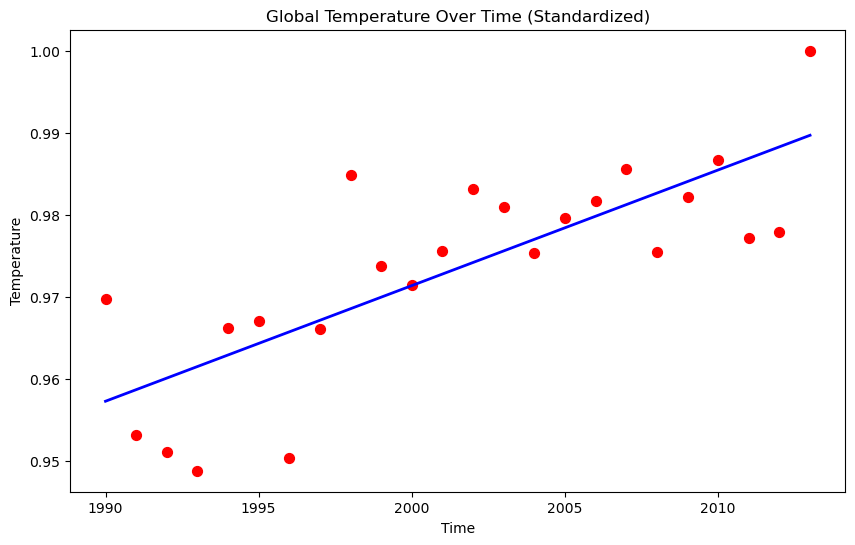

In [12]:
# Plot Temperature over time
m, b = np.polyfit(years, stand_temps, 1)

plt.figure(figsize=(10, 6))
plt.plot(years, m * years + b, color='blue', linewidth=2)
plt.scatter(list(range(1990, 2014)), stand_temps, c='red', marker='o', s=50)
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Global Temperature Over Time (Standardized)')
plt.show()

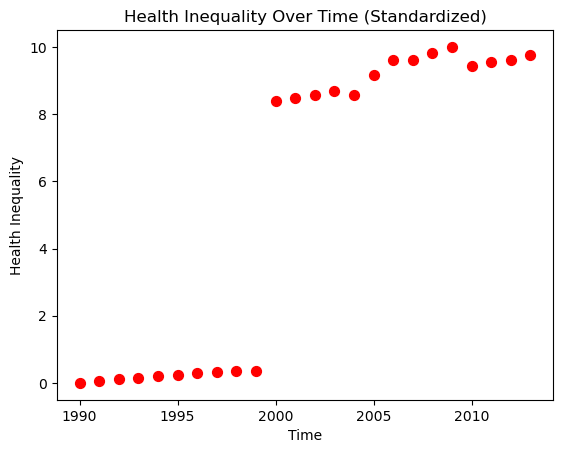

In [13]:
# Plot inequality over time
plt.scatter(list(range(1990, 2014)), stand_factors, c='red', marker='o', s=50)
plt.xlabel('Time')
plt.ylabel('Health Inequality')
plt.title('Health Inequality Over Time (Standardized)')

plt.show()

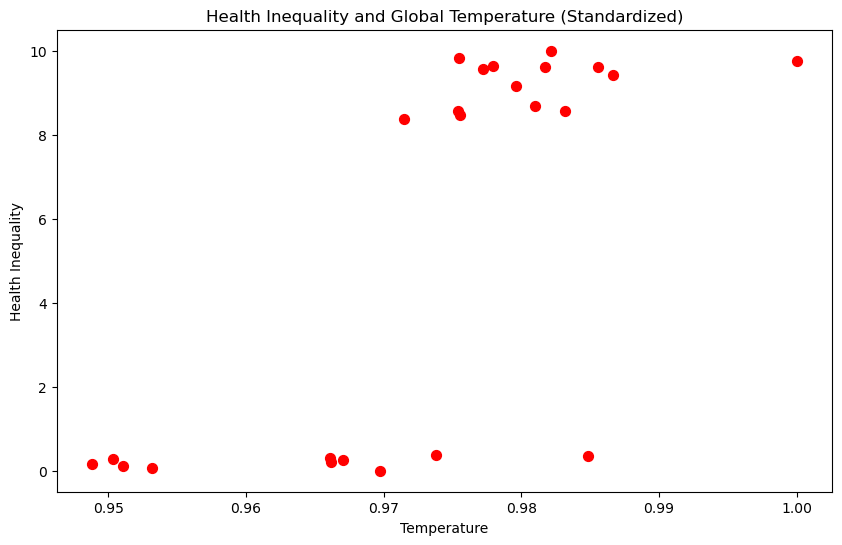

In [14]:
# Plot Inequality dependent on temperature
m, b = np.polyfit(stand_temps, stand_factors, 1)

plt.figure(figsize=(10, 6))
plt.scatter(stand_temps, stand_factors, c='red', marker='o', s=50)
plt.xlabel('Temperature')
plt.ylabel('Health Inequality')
plt.title('Health Inequality and Global Temperature (Standardized)')
plt.show()